This test is failing... https://tssw-ci.lsst.org/job/LSST_Telescope-and-Site/job/ts_wep/job/PR-152/2/testReport/junit/tests.task.test_generateDonutDirectDetectTask/TestGenerateDonutDirectDetectTask/testPipeline/ figure out why (and if I can reproduce that...)

The test is at https://github.com/lsst-ts/ts_wep/blob/develop/tests/task/test_generateDonutDirectDetectTask.py

In [1]:
from lsst.ts.wep import Utilitytility

In [2]:
import os
import unittest
import numpy as np
import pandas as pd
from lsst.daf import butler as dafButler
from lsst.ts.wep.Utility import getModulePath
from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
    GenerateDonutDirectDetectTask,
    GenerateDonutDirectDetectTaskConfig,
)
from lsst.ts.wep.Utility import runProgram, writePipetaskCmd, writeCleanUpRepoCmd


In [5]:
config = GenerateDonutDirectDetectTaskConfig()
task = GenerateDonutDirectDetectTask(config=config)

moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
centerRaft = ["R22_S10", "R22_S11"]

butler = dafButler.Butler(repoDir)
registry = butler.registry

In [6]:
# Run pipeline command
runName = "run1"
instrument = "lsst.obs.lsst.LsstCam"
collections = "refcats/gen2,LSSTCam/calib,LSSTCam/raw/all"
exposureId = 4021123106001  # Exposure ID for test extra-focal image
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
pipelineYaml = os.path.join(
    testPipelineConfigDir, "testDonutDirectDetectPipeline.yaml"
)
pipetaskCmd = writePipetaskCmd(
    repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml
)
# Update task configuration to match pointing information
pipetaskCmd += f" -d 'exposure IN ({exposureId})'"

# Check that run doesn't already exist due to previous improper cleanup
collectionsList = list(registry.queryCollections())
if runName in collectionsList:
    cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)
    runProgram(cleanUpCmd)

# Run pipeline task
runProgram(pipetaskCmd)

No RUN collections were found.


lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 4 quanta for 2 tasks, graph ID: '1665091084.7161024-402982'
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter g.
lsst.isr INFO: Setting rough magnitude zero point for filter g: 30.940228
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTCam', detector: 93, exposure: 4021123106001, ...} took 5.181 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 3 remain out of total 4 quanta.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero

In [7]:
# Test instrument matches
pipelineButler = dafButler.Butler(repoDir)
donutCatDf_S11 = pipelineButler.get(
    "donutCatalog",
    dataId={"instrument": "LSSTCam", "detector": 94, "visit": exposureId},
    collections=[f"{runName}"],
)
donutCatDf_S10 = pipelineButler.get(
    "donutCatalog",
    dataId={"instrument": "LSSTCam", "detector": 93, "visit": exposureId},
    collections=[f"{runName}"],
)

In [9]:
# get images 
exposure = pipelineButler.get("postISRCCD",
                              dataId={"instrument": "LSSTCam", "detector": 94, "exposure": exposureId},
    collections=[f"{runName}"]
)

Text(0.5, 1.0, 'detector 94, i.e. S10')

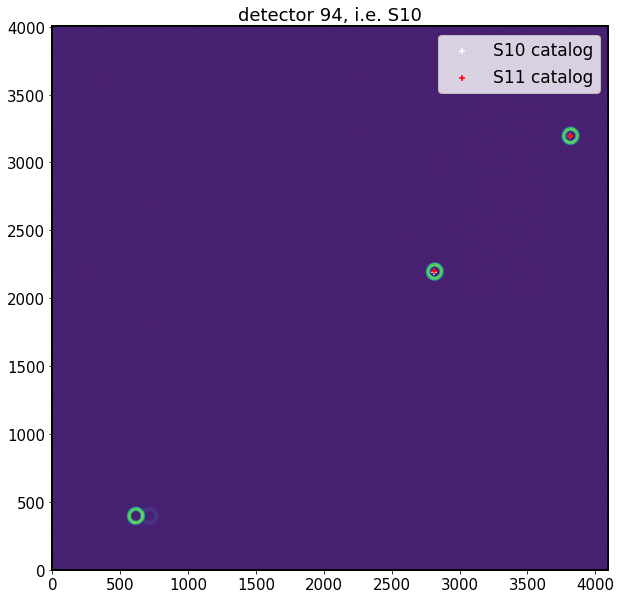

In [45]:
# show the image and the sources 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
%matplotlib inline

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(exposure.image.array, origin='lower')
for cat,label,c in  zip([donutCatDf_S10, donutCatDf_S11],
                      ['S10','S11'],['w','r']):
    ax.scatter(cat['centroid_x'] , cat['centroid_y'],
          marker='+',c=c,label=f'{label} catalog')
ax.legend(fontsize=17)
ax.set_title('detector 94, i.e. S10')

In [15]:
# Check 2 unblended sources in each detector
#assertEqual(len(donutCatDf_S11), 2)
#assertEqual(len(donutCatDf_S10), 2)
len(donutCatDf_S11)

2

In [16]:
len(donutCatDf_S10)

2

In [17]:
donutCatDf_S11  # detector 95

,centroid_y,centroid_x,blended,blended_with,num_blended_neighbors,detector,coord_ra,coord_dec
0,3196,3815,False,None,0,R22_S11,0.001158,0.001714
2,2198,2814,False,None,0,R22_S11,0.000191,0.000743


In [18]:
donutCatDf_S10 # detector 94

,centroid_y,centroid_x,blended,blended_with,num_blended_neighbors,detector,coord_ra,coord_dec
1,2190,2813,False,None,0,R22_S10,0.000183,-0.003354
2,3194,3812,False,None,0,R22_S10,0.001156,-0.002386


In [19]:
outputDf = pd.concat([donutCatDf_S11, donutCatDf_S10])

In [ ]:
# Check outputs are correct
outputDf = pd.concat([donutCatDf_S11, donutCatDf_S10])
self.assertEqual(len(outputDf), 4)
self.assertCountEqual(
    outputDf.columns,
    [
        "coord_ra",
        "coord_dec",
        "centroid_x",
        "centroid_y",
        "blended",
        "blended_with",
        "num_blended_neighbors",
        "detector",
    ],
)
self.assertCountEqual(
    [3196, 2198, 2190, 3194],
    outputDf["centroid_y"],
)
self.assertCountEqual(
    [3815, 2814, 2813, 3812],
    outputDf["centroid_x"],
)